In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

# initializing lemmatizer
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wordnet_lemmatizer.lemmatize)
 
# ===========helper methods ========================================
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

def stop_words_list():
    """
        A stop list specific to the observed timelines composed of noisy words
        This list would change for different set of timelines
    """
    stop_words = ['bc', 'http', 'https', 'co', 'rt', 'one', 'us', 'new',
              'lol', 'may', 'get', 'want', 'like', 'love', 'no', 'thank', 'would', 'thanks',
              'via', 'today', 'gt', 'great', 'watch', 'watched', 'season',
              '00p']

    stoplist  = set( nltk.corpus.stopwords.words("english") + stop_words)
    return stoplist

def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

def tokenize(text):
    """
    helper function to readTweets() removes url and tokenizes text
    :param text
    """
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = re.sub(r"""[\'\"]""",'', text)
    regexps = (
        r"""(?:[\w_]+)""",                          # regular word
        r"""(?:[a-z][a-z'\-_]+[a-z])"""             # word with an apostrophe or a dash
    )
    tokens_regexp = re.compile(r"""(%s)""" % "|".join(regexps),
                               re.VERBOSE | re.I | re.UNICODE)
    return tokens_regexp.findall(text)

def replace_acronym(tokens, slang_dict):
    new_tokens = []
    for token in tokens:
        if token in slang_dict:
            new_tokens.extend(slang_dict[token].split())
        else:
            new_tokens.append(token)
    return new_tokens

def tokenize_and_lemmatize(text, slang_dict, stop_words):
    # get the tokens, lowercase - replace acronym
    lowered = [item.lower() for item in tokenize(text)]
    tokens = replace_acronym(lowered, slang_dict)

    
    tokens_pos = pos_tag(tokens)
    words = []
    for token in tokens_pos:
        pos = get_wordnet_pos(token[1])
        # if verb, noun, adj or adverb include them after lemmatization
        if pos is not None and token[0] not in stop_words:
            try:
                tok = lemmatize(token[0], pos)
                words.append(tok)
            except UnicodeDecodeError:
                pass
    # print words
    return words

def read_in_dict(filename):
    dict = {}
    with open(filename) as f:
        for line in f.readlines():
            parts = line.partition(":")
            dict[parts[0].strip()] = parts[2].strip()
    return dict

In [3]:
test_df = pd.read_csv("data/manually_labelled.csv",sep=';' , low_memory=False)

Reading the data set

In [5]:
print(test_df.tail())

         label                                              tweet   user_id
210  #personal  @ashleynconnor applying Chapstick after the de...  73306114
211  #personal  I need to remember to order my backpack tomorr...  73306114
212  #personal  RT @harto: remembering tomorrow is Friday is l...  73306114
213  #personal  @ittybittyanniee omg I am terrified to watch t...  73306114
214  #personal          #Scandalfinale tonight and I'm not ready.  73306114


In [9]:
# convert the pandas series (tweet text) to numpy array
text = test_df.iloc[:, 1]
tweet_text = np.array(text)

Take the column of tweet text and convert to numpy array, for use in tfidf

In [11]:
def get_tfidf_model(texts, stop_words= None, slang_dict=None):
    stop_words = stop_words_list()
    vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 )

    #print ("vocabulary_: ", vectorizer.vocabulary_)
    
    tfidf_model = vectorizer.fit_transform(texts)
    return tfidf_model
    

slang_dict = read_in_dict("data/out_slang_map.csv")
tfidf_model = get_tfidf_model(tweet_text[:1000], stop_words_list(), slang_dict)

print(tfidf_model.shape)

(215, 145)


In [12]:
# gmm maximisation
clf = mixture.GMM(n_components=10, n_iter=500, n_init=10)
print (clf)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=10, n_iter=500, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


Aikaki Information Criteria(AIC) and the Bayesian Information Criterion(BIC)

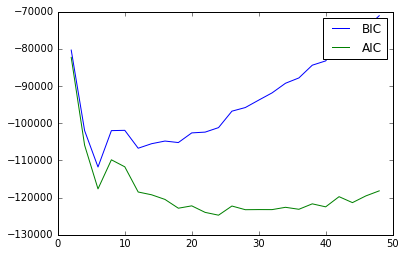

In [13]:
n_estimators = np.arange(2,50, step=2)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

n             bic              aic 
2             -80341              -82299
3             -89155              -92094
4             -105210              -109130
5             -109424              -114325
6             -110592              -116474
7             -112902              -119765
8             -112515              -120358
9             -107488              -116313


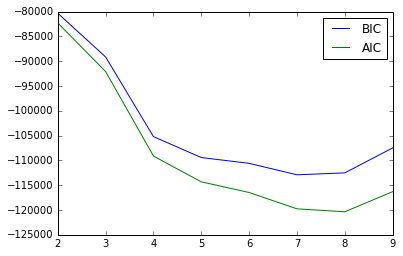

In [14]:
n_estimators = np.arange(2,10, step=1)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

i = 1
print("n             bic              aic ")
for x, y in zip(bics, aics):
    i += 1
    print("%d             %d              %d" % (i, x, y) )

In [15]:
# Log probabilities of each data point in tfarray
clf = mixture.GMM(n_components=9, n_iter=500).fit(tfarray)
print( clf.score(tfarray))


[ 306.71023514  364.96812111  364.96812111  364.96812111  364.96812111
  364.96812111  364.96812111  364.96812111  364.96812111  196.87909743
  364.96812111  364.96812111  364.96812111  364.96812111  360.21508605
  364.96812111  364.96812111  364.96812111  360.21508605  364.96812111
  360.21508605  310.41430602  318.15956385  317.74583818  211.07210686
  184.80203337  360.21508605  204.75345307  315.76328955  204.75345307
  360.21508605  336.65736228  321.91258871  210.58864985  204.75345307
  201.02723195  321.91258871  204.75345307  360.21508605  329.82375975
  329.5375646   209.68298806  176.67709578  182.91723271  174.77908271
  176.78077674  294.76721428  194.059281    185.34175325  207.01270359
  193.85008341  359.16153985  359.16153985  199.865921    319.95628367
  332.02471085  189.34403654  190.89432014  178.33627445  195.5230355
  348.93440372  206.74675277  360.21508605  360.21508605  186.49892391
  209.46548426  198.67763784  166.43802844  205.79178994  188.52715591
  307.2

<hr>
<b> GMM EM gives 7 clusters </b>


In [16]:
# true labels
t_labels = test_df.iloc[:, 1]

# run k means :
clusters = 7
km_model = KMeans(n_clusters=clusters)
cluster = km_model.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.136781
Adjusted Rand Score                : 0.007527
Adjusted Mutual Information Score  : 0.026216
Normalized Mutual Information Score: 0.583606
Normalized Mutual Information Score: 0.583606
Homogeniety Score                  : 0.340596
Completeness Score                 : 1.000000


In [17]:
# run Birch:
birch = Birch(n_clusters=clusters)
cluster = birch.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.062124
Adjusted Rand Score                : 0.002943
Adjusted Mutual Information Score  : 0.017868
Normalized Mutual Information Score: 0.503845
Normalized Mutual Information Score: 0.503845
Homogeniety Score                  : 0.253860
Completeness Score                 : 1.000000


In [18]:
# run SpectralClustering
spectral = SpectralClustering(n_clusters=clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
cluster = spectral.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : -0.072584
Adjusted Rand Score                : 0.001385
Adjusted Mutual Information Score  : 0.011701
Normalized Mutual Information Score: 0.443643
Normalized Mutual Information Score: 0.443643
Homogeniety Score                  : 0.196820
Completeness Score                 : 1.000000


/home/swati/anaconda3/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [19]:
# db scan
dbscan = DBSCAN(eps=.2)
cluster = dbscan.fit_predict(tfidf_model)
print("clusters by DBSCAN: %d" % len(set(cluster)))
# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))


clusters by DBSCAN: 4
Silhouette score                   : -0.061650
Adjusted Rand Score                : 0.000737
Adjusted Mutual Information Score  : 0.007136
Normalized Mutual Information Score: 0.344540
Normalized Mutual Information Score: 0.344540
Homogeniety Score                  : 0.118708
Completeness Score                 : 1.000000
